In [1]:
import pandas as pd
import sklearn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi")

2025/08/05 18:48:15 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', creation_time=1754419695541, experiment_id='1', last_update_time=1754419695541, lifecycle_stage='active', name='nyc-taxi', tags={}>

In [25]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [26]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred)

95.55970720911512

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


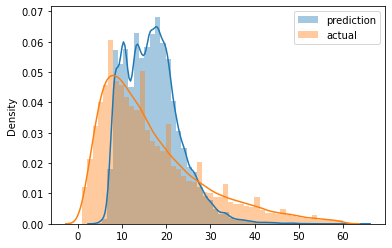

In [27]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [28]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [29]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [30]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [31]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [32]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred)

55.94385011743112

In [34]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

## logging model as an artifact

In [47]:
with mlflow.start_run():
    mlflow.set_tag("developer","YW")

    mlflow.log_param('train-data-path','./data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path','./data/green_tripdata_2021-02.parquet')
    
    alpha = 0.05

    mlflow.log_param('alpha',alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred,squared=False)
    mlflow.log_metric('rmse',rmse)

    mlflow.log_artifact(local_path = 'models/lin_reg.bin',artifact_path='models_pickle')

## mlflow tracking experiments in hyper-param tuning

In [41]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [42]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [43]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [44]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:31:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.59198                          
[1]	validation-rmse:11.03332                          
[2]	validation-rmse:10.53247                          
[3]	validation-rmse:10.08441                          
[4]	validation-rmse:9.68405                           
[5]	validation-rmse:9.32743                           
[6]	validation-rmse:9.01034                           
[7]	validation-rmse:8.72971                           
[8]	validation-rmse:8.48060                           
[9]	validation-rmse:8.26116                           
[10]	validation-rmse:8.06742                          
[11]	validation-rmse:7.89725                          
[12]	validation-rmse:7.74751                          
[13]	validation-rmse:7.61555                          
[14]	validation-rmse:7.49987                          
[15]	validation-rmse:7.39862                          
[16]	validation-rmse:7.30923                          
[17]	validation-rmse:7.23089                          
[18]	valid

KeyboardInterrupt: 

## mlflow autolog

In [45]:
params = {'learning_rate':0.205,
          'max_depth':17,
          'min_child_weright':1.24,
          'objective':'reg:linear',
          'reg_alpha':0.2856789,
          'reg_lambda':0.0042644,
          'seed':42}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2025/08/05 19:54:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2025/08/05 19:54:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '28e8dd6dd0b74aa9922e447527d4cac0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:54:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:54:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_child_weright" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.62221
[1]	validation-rmse:9.46152
[2]	validation-rmse:8.62559
[3]	validation-rmse:8.03938
[4]	validation-rmse:7.63140
[5]	validation-rmse:7.34303
[6]	validation-rmse:7.14514
[7]	validation-rmse:7.00769
[8]	validation-rmse:6.91006
[9]	validation-rmse:6.83969
[10]	validation-rmse:6.79085
[11]	validation-rmse:6.75536
[12]	validation-rmse:6.72870
[13]	validation-rmse:6.70908
[14]	validation-rmse:6.69559
[15]	validation-rmse:6.68651
[16]	validation-rmse:6.67702
[17]	validation-rmse:6.66899
[18]	validation-rmse:6.66426
[19]	validation-rmse:6.65980
[20]	validation-rmse:6.65630
[21]	validation-rmse:6.65304
[22]	validation-rmse:6.65141
[23]	validation-rmse:6.64940
[24]	validation-rmse:6.64617
[25]	validation-rmse:6.64354
[26]	validation-rmse:6.64098
[27]	validation-rmse:6.63857
[28]	validation-rmse:6.63722
[29]	validation-rmse:6.63590
[30]	validation-rmse:6.63375
[31]	validation-rmse:6.63296
[32]	validation-rmse:6.63197
[33]	validation-rmse:6.63068
[34]	validation-rmse:6.

2025/08/05 19:57:09 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/08/05 19:57:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:57:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/08/05 19:57:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


## Log model with method: mlflow.\<framework\>.log_model(model, artifact_path='path')

In [48]:
with mlflow.start_run():
    
    best_params = {'learning_rate':0.205,
            'max_depth':17,
            'min_child_weright':1.24,
            'objective':'reg:linear',
            'reg_alpha':0.2856789,
            'reg_lambda':0.0042644,
            'seed':42}
    
    mlflow.log_params(best_params)
    
    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val,y_pred, squared=False)
    mlflow.log_metric('rmse',rmse)

    mlflow.xgboost.log_model(booster,artifact_path='model_mlflow')

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:28:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:28:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_child_weright" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.62221
[1]	validation-rmse:9.46152
[2]	validation-rmse:8.62559
[3]	validation-rmse:8.03938
[4]	validation-rmse:7.63140
[5]	validation-rmse:7.34303
[6]	validation-rmse:7.14514
[7]	validation-rmse:7.00769
[8]	validation-rmse:6.91006
[9]	validation-rmse:6.83969
[10]	validation-rmse:6.79085
[11]	validation-rmse:6.75536
[12]	validation-rmse:6.72870
[13]	validation-rmse:6.70908
[14]	validation-rmse:6.69559
[15]	validation-rmse:6.68651
[16]	validation-rmse:6.67702
[17]	validation-rmse:6.66899
[18]	validation-rmse:6.66426
[19]	validation-rmse:6.65980
[20]	validation-rmse:6.65630
[21]	validation-rmse:6.65304
[22]	validation-rmse:6.65141
[23]	validation-rmse:6.64940
[24]	validation-rmse:6.64617
[25]	validation-rmse:6.64354
[26]	validation-rmse:6.64098
[27]	validation-rmse:6.63857
[28]	validation-rmse:6.63722
[29]	validation-rmse:6.63590
[30]	validation-rmse:6.63375
[31]	validation-rmse:6.63296
[32]	validation-rmse:6.63197
[33]	validation-rmse:6.63068
[34]	validation-rmse:6.

2025/08/05 20:31:09 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/08/05 20:31:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:31:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:31:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


## disable autolog and log preprocessor as artifact

In [49]:
mlflow.xgboost.autolog(disable=True)

In [50]:
with mlflow.start_run():
    
    best_params = {'learning_rate':0.205,
            'max_depth':17,
            'min_child_weright':1.24,
            'objective':'reg:linear',
            'reg_alpha':0.2856789,
            'reg_lambda':0.0042644,
            'seed':42}
    
    mlflow.log_params(best_params)
    
    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val,y_pred, squared=False)
    mlflow.log_metric('rmse',rmse)

    with open('models/preprocessor.b','wb') as f_out:
        pickle.dump(dv,f_out)

    mlflow.log_artifact('models/preprocessor.b',artifact_path='preprocessor')

    mlflow.xgboost.log_model(booster,artifact_path='model_mlflow')

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:47:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:47:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_child_weright" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.62221
[1]	validation-rmse:9.46152
[2]	validation-rmse:8.62559
[3]	validation-rmse:8.03938
[4]	validation-rmse:7.63140
[5]	validation-rmse:7.34303
[6]	validation-rmse:7.14514
[7]	validation-rmse:7.00769
[8]	validation-rmse:6.91006
[9]	validation-rmse:6.83969
[10]	validation-rmse:6.79085
[11]	validation-rmse:6.75536
[12]	validation-rmse:6.72870
[13]	validation-rmse:6.70908
[14]	validation-rmse:6.69559
[15]	validation-rmse:6.68651
[16]	validation-rmse:6.67702
[17]	validation-rmse:6.66899
[18]	validation-rmse:6.66426
[19]	validation-rmse:6.65980
[20]	validation-rmse:6.65630
[21]	validation-rmse:6.65304
[22]	validation-rmse:6.65141
[23]	validation-rmse:6.64940
[24]	validation-rmse:6.64617
[25]	validation-rmse:6.64354
[26]	validation-rmse:6.64098
[27]	validation-rmse:6.63857
[28]	validation-rmse:6.63722
[29]	validation-rmse:6.63590
[30]	validation-rmse:6.63375
[31]	validation-rmse:6.63296
[32]	validation-rmse:6.63197
[33]	validation-rmse:6.63068
[34]	validation-rmse:6.

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:49:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


## access a logged model

In [51]:

logged_model = 'runs:/995385cc53d44a12864148edf8068bda/model_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [52]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model_mlflow
  flavor: mlflow.xgboost
  run_id: 995385cc53d44a12864148edf8068bda

In [53]:
xgboost_model = mlflow.xgboost.load_model('runs:/995385cc53d44a12864148edf8068bda/model_mlflow')
xgboost_model

In [54]:
y_pred = xgboost_model.predict(valid)
y_pred[:10]

array([15.990624 ,  7.1278796, 16.511992 , 23.918629 ,  9.358755 ,
       17.003654 , 12.562525 ,  8.501214 ,  8.900724 , 16.126453 ],
      dtype=float32)

In [55]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

KeyboardInterrupt: 